In [1]:
import os
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from matplotlib import pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# use BOTH training and testing data for training
batch_size = 256
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(256)



In [3]:
        '''
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
        '''

'\nkeras.Input(shape=(28, 28, 1)),\nlayers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),\nlayers.LeakyReLU(alpha=0.2),\nlayers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),\nlayers.LeakyReLU(alpha=0.2),\nlayers.GlobalMaxPooling2D(),\nlayers.Dense(1),\n'

In [4]:

discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=.2),
        layers.Dropout(0.4),
        ########################
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=.2),
        layers.Dropout(0.4),
        ########################
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=.2),
        layers.Dropout(0.4),
        ########################    
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=.2),
        layers.Dropout(0.4),
        ########################
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)       

In [5]:
        '''
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        '''

'\nkeras.Input(shape=(latent_dim,)),\n# We want to generate 128 coefficients to reshape into a 7x7x128 map\nlayers.Dense(7 * 7 * 128),\nlayers.LeakyReLU(alpha=0.2),\nlayers.Reshape((7, 7, 128)),\nlayers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),\nlayers.LeakyReLU(alpha=0.2),\nlayers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),\nlayers.LeakyReLU(alpha=0.2),\nlayers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),\n'

In [6]:
latent_dim = 100


generator = keras.Sequential(
    [
        keras.Input(shape=(100,)),
        layers.Dense(units=7*7*192, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7, 7, 192)),
        layers.Dropout(0.40),
        ########
        layers.UpSampling2D(size=(2,2)),
        layers.Conv2DTranspose(96, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        ########
        layers.UpSampling2D(size=(2,2)),
        layers.Conv2DTranspose(48, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        ########
        layers.Conv2DTranspose(24, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same',use_bias=False , activation='tanh'),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9408)              940800    
_________________________________________________________________
batch_normalization (BatchNo (None, 9408)              37632     
_________________________________________________________________
re_lu (ReLU)                 (None, 9408)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 192)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 192)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 192)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 96)        46

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


In [8]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=16, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            #if epoch in [0,1,2,3,4,5,6,7,8,9,10,11, 200, 400, 600]:
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


In [9]:
epochs = 600
with tf.device("/gpu:0"):
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.00003),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.00003),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=16, latent_dim=latent_dim)]
)

Epoch 1/600
274/274 [==============================] - 14s 50ms/step - d_loss: 0.5743 - g_loss: 0.7502
Epoch 2/600
274/274 [==============================] - 13s 48ms/step - d_loss: 0.3603 - g_loss: 1.5253
Epoch 3/600
274/274 [==============================] - 13s 49ms/step - d_loss: 0.3392 - g_loss: 1.9417
Epoch 4/600
274/274 [==============================] - 14s 50ms/step - d_loss: 0.3859 - g_loss: 1.7103
Epoch 5/600
274/274 [==============================] - 14s 51ms/step - d_loss: 0.3214 - g_loss: 1.8314
Epoch 6/600
274/274 [==============================] - 14s 52ms/step - d_loss: 0.3087 - g_loss: 1.9386
Epoch 7/600
274/274 [==============================] - 14s 52ms/step - d_loss: 0.3436 - g_loss: 1.8751
Epoch 8/600
274/274 [==============================] - 14s 52ms/step - d_loss: 0.3785 - g_loss: 1.7403
Epoch 9/600
274/274 [==============================] - 14s 53ms/step - d_loss: 0.4113 - g_loss: 1.6353
Epoch 10/600
274/274 [==============================] - 14s 53ms/step - d

274/274 [==============================] - 15s 53ms/step - d_loss: 0.6314 - g_loss: 0.9405
Epoch 80/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6398 - g_loss: 0.9473
Epoch 81/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6330 - g_loss: 0.9276
Epoch 82/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6315 - g_loss: 0.9413
Epoch 83/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6405 - g_loss: 0.9420
Epoch 84/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6347 - g_loss: 0.9159
Epoch 85/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6418 - g_loss: 0.9351
Epoch 86/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6349 - g_loss: 0.9157
Epoch 87/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6340 - g_loss: 0.9321
Epoch 88/600
274/274 [==============================] - 15s 54ms/step - d_los

274/274 [==============================] - 15s 55ms/step - d_loss: 0.6587 - g_loss: 0.8518
Epoch 158/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6578 - g_loss: 0.8563
Epoch 159/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6602 - g_loss: 0.8611
Epoch 160/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6613 - g_loss: 0.8629
Epoch 161/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6618 - g_loss: 0.8467
Epoch 162/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6620 - g_loss: 0.8466
Epoch 163/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6588 - g_loss: 0.8369
Epoch 164/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6597 - g_loss: 0.8403
Epoch 165/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6597 - g_loss: 0.8476
Epoch 166/600
274/274 [==============================] - 15s 54ms/ste

274/274 [==============================] - 15s 54ms/step - d_loss: 0.6636 - g_loss: 0.8300
Epoch 236/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6644 - g_loss: 0.8290
Epoch 237/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6616 - g_loss: 0.8233
Epoch 238/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6632 - g_loss: 0.8412
Epoch 239/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6639 - g_loss: 0.8401
Epoch 240/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6625 - g_loss: 0.8422
Epoch 241/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6605 - g_loss: 0.8379
Epoch 242/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6628 - g_loss: 0.8339
Epoch 243/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6610 - g_loss: 0.8369
Epoch 244/600
274/274 [==============================] - 15s 54ms/ste

274/274 [==============================] - 15s 54ms/step - d_loss: 0.6588 - g_loss: 0.8466
Epoch 314/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6579 - g_loss: 0.8419
Epoch 315/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6554 - g_loss: 0.8372
Epoch 316/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6564 - g_loss: 0.8512
Epoch 317/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6563 - g_loss: 0.8507
Epoch 318/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6564 - g_loss: 0.8447
Epoch 319/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6556 - g_loss: 0.8498
Epoch 320/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6571 - g_loss: 0.8585
Epoch 321/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6563 - g_loss: 0.8523
Epoch 322/600
274/274 [==============================] - 15s 54ms/ste

274/274 [==============================] - 15s 53ms/step - d_loss: 0.6467 - g_loss: 0.8768
Epoch 392/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6448 - g_loss: 0.8750
Epoch 393/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6460 - g_loss: 0.8786
Epoch 394/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6453 - g_loss: 0.8792
Epoch 395/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6467 - g_loss: 0.8929
Epoch 396/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6449 - g_loss: 0.8943
Epoch 397/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6448 - g_loss: 0.8770
Epoch 398/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6451 - g_loss: 0.8654
Epoch 399/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6449 - g_loss: 0.8693
Epoch 400/600
274/274 [==============================] - 15s 53ms/ste

274/274 [==============================] - 15s 53ms/step - d_loss: 0.6330 - g_loss: 0.9126
Epoch 470/600
274/274 [==============================] - 14s 53ms/step - d_loss: 0.6319 - g_loss: 0.9129
Epoch 471/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6329 - g_loss: 0.9149
Epoch 472/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6305 - g_loss: 0.9038
Epoch 473/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6329 - g_loss: 0.9154
Epoch 474/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6313 - g_loss: 0.9157
Epoch 475/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6314 - g_loss: 0.9142
Epoch 476/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6311 - g_loss: 0.9158
Epoch 477/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6294 - g_loss: 0.9106
Epoch 478/600
274/274 [==============================] - 15s 53ms/ste

274/274 [==============================] - 15s 53ms/step - d_loss: 0.6149 - g_loss: 0.9678
Epoch 548/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6147 - g_loss: 0.9645
Epoch 549/600
274/274 [==============================] - 14s 53ms/step - d_loss: 0.6138 - g_loss: 0.9615
Epoch 550/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6144 - g_loss: 0.9729
Epoch 551/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6128 - g_loss: 0.9668
Epoch 552/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6133 - g_loss: 0.9659
Epoch 553/600
274/274 [==============================] - 15s 54ms/step - d_loss: 0.6125 - g_loss: 0.9735
Epoch 554/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6122 - g_loss: 0.9677
Epoch 555/600
274/274 [==============================] - 15s 53ms/step - d_loss: 0.6125 - g_loss: 0.9744
Epoch 556/600
274/274 [==============================] - 15s 54ms/ste

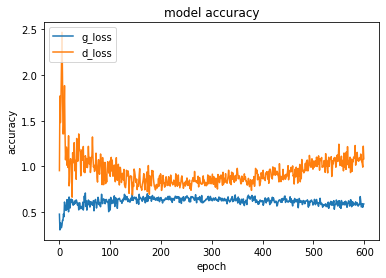

In [10]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['g_loss', 'd_loss'], loc='upper left')
plt.show()

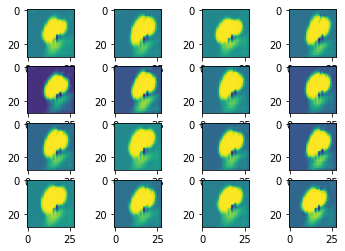

In [11]:
from IPython.display import Image, display
import matplotlib.image as mpimg
dir = '/home/ubuntuhome/Desktop/project_pics/600'
#display(Image("/home/ubuntuhome/Desktop/project_pics/600/generated_img_0_599.png"))
img = mpimg.imread(dir + "/generated_img_0_0.png")
img2 = mpimg.imread(dir + "/generated_img_1_0.png")
img3 = mpimg.imread(dir + "/generated_img_2_0.png")
img4 = mpimg.imread(dir + "/generated_img_3_0.png")
img5 = mpimg.imread(dir + "/generated_img_4_0.png")
img6 = mpimg.imread(dir + "/generated_img_5_0.png")
img7 = mpimg.imread(dir + "/generated_img_6_0.png")
img8 = mpimg.imread(dir + "/generated_img_7_0.png")
img9 = mpimg.imread(dir + "/generated_img_8_0.png")
img10 = mpimg.imread(dir + "/generated_img_9_0.png")
img11 = mpimg.imread(dir + "/generated_img_10_0.png")
img12 = mpimg.imread(dir + "/generated_img_11_0.png")
img13 = mpimg.imread(dir + "/generated_img_12_0.png")
img14 = mpimg.imread(dir + "/generated_img_13_0.png")
img15 = mpimg.imread(dir + "/generated_img_14_0.png")
img16 = mpimg.imread(dir + "/generated_img_15_0.png")
import numpy as np
import matplotlib.pyplot as plt


#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,4) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(img)
axarr[0,1].imshow(img2)
axarr[0,2].imshow(img3)
axarr[0,3].imshow(img4)
axarr[1,0].imshow(img5)
axarr[1,1].imshow(img6)
axarr[1,2].imshow(img7)
axarr[1,3].imshow(img8)
axarr[2,0].imshow(img9)
axarr[2,1].imshow(img10)
axarr[2,2].imshow(img11)
axarr[2,3].imshow(img12)
axarr[3,0].imshow(img13)
axarr[3,1].imshow(img14)
axarr[3,2].imshow(img15)
axarr[3,3].imshow(img16)